In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()

# Lifting bodies

We will apply the vortex panel method developed in the last section to the prediction of lift on wing sections.

## Foil section geometry

To find the lift on a foil, we first need to define the geometry. Let's use a symmetric Jukowski foil for now. This foil shape is obtained by applying the following mapping

$$ x' = \frac x2 (1+1/r^2), \quad y' = \frac y2 (1-1/r^2),\quad r^2= x^2+y^2 $$

to the points on a circle which intersects $x,y=1,0$. Shifting the center of the circle an amount $\Delta x$ sets the thickness of the foil. I've followed this procedure in the function `make_jukowski`. Let's import it:

In [2]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from VortexPanel import Panel, solve_gamma, plot_flow, make_circle, make_jukowski
help(make_jukowski)

Help on function make_jukowski in module VortexPanel:

make_jukowski(N, dx=0.18, dtheta=0, dr=0)
    # make a jukowski foil



The arguments are a number of points $N$, the x-shift `dx`$=\Delta x$, and similar shifts to the angle `dtheta`$=\Delta \theta$ and radius `dr`$=\Delta r$. Let's test it out.

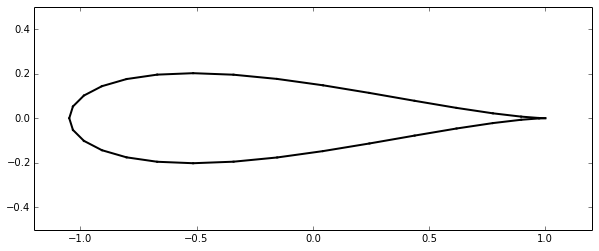

In [3]:
N = 32
foil = make_jukowski(N)

pyplot.figure(figsize=(10,4))
pyplot.axis([-1.2,1.2,-.5,.5])
for p in foil: p.plot()

##### Quiz 1

How can you get a cambered (ie, curved) foil shape?

1. Shift the center right or left.
1. Rotate the circle around (1,0).
1. Change the circle's radius.
---

We're going to use the symmetric foil with a sharp edge - so put things back when you're done.

## Lift force

We could determine the lift by evaluating a pressure integral as we did in the previous notebook - it would simply be 

$$ L = -\oint p n_y da $$

However, the Kutta-Joukowski lift force on a body in potential flow is even easier:

$$ L = -\rho U_\infty \Gamma $$

where $\Gamma$ is the total circulation. For a continuous vortex sheet this is given by $\Gamma=\int\gamma(s) ds $.

We non-dimensionalize the lift as

$$ C_L =\frac L{\tfrac 12 \rho U_\infty^2 c} $$

where $c$ is the coord length, the distance from the leading to trailing edge.

---

##### Quiz 2

What is the psuedo-code for the lift coefficient in terms `gamma` and the panel half-width `S`?
- `-sum(gamma)/(2*c)`
- `-sum(gamma*2*S)/(0.5*c)`
- `-sum(gamma)*2*S/(0.5*c)`

---
Now fill in this expression below.

In [4]:
def C_L(panels):
    # choord length
    c = max([p.xc for p in panels])-min([p.xc for p in panels])
    gamma = [p.gamma for p in panels]
    S = [p.S for p in panels]
    
    return numpy.NaN # replace!

---

So now let's get the lift on the foil:

In [5]:
solve_gamma(foil)
print('C_L ='+'%.2e'%C_L(foil))

C_L =nan


That can't be right...

Oh, of course. We need an angle of attack to get lift. No problem:

C_L =nan


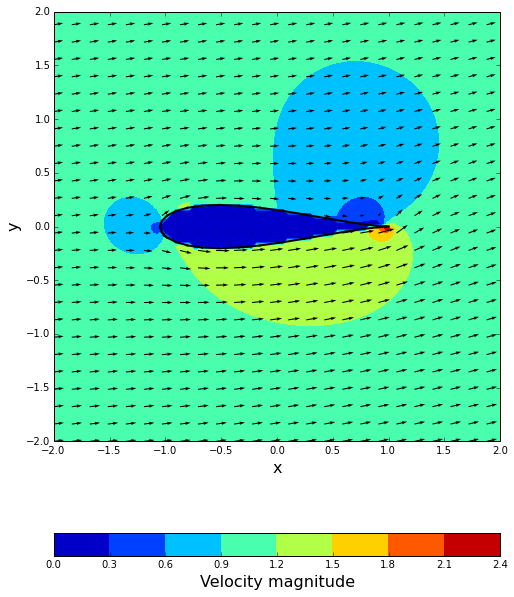

In [6]:
alpha = numpy.pi/16         # set angle of attack
solve_gamma(foil,alpha)     # solve for gamma
plot_flow(foil,alpha)       # plot the flow
print('C_L ='+'%.2e'%C_L(foil))

Sigh. There are so many things wrong with this picture...

 - The flow is faster on the underside of the foil, causing the lift to be negative. 
 - The rear stagnation point is on the upper side of the foil.
 - There is a singularity on the lower side of the trailing edge.

These are all physically incorrect!

## Indeterminate vortex strength 
All of these are symptoms of the same issue. To figure out what the problem is, let's go back to the circle geometry.

##### Quiz 3

What can we do to the circle flow to generate lift force?

1. Change the angle of attack
1. Superimpose a vortex
1. Increase the resolution

Note that the addition of a vortex of strength $\Gamma^+$ to the center of the circle has *exactly* the same effect on the external flow as changing $\gamma_i$ by an amount $\Delta\gamma=\frac {\Gamma^+}{2\pi R}$.

Try it out with the code below:

C_L =nan


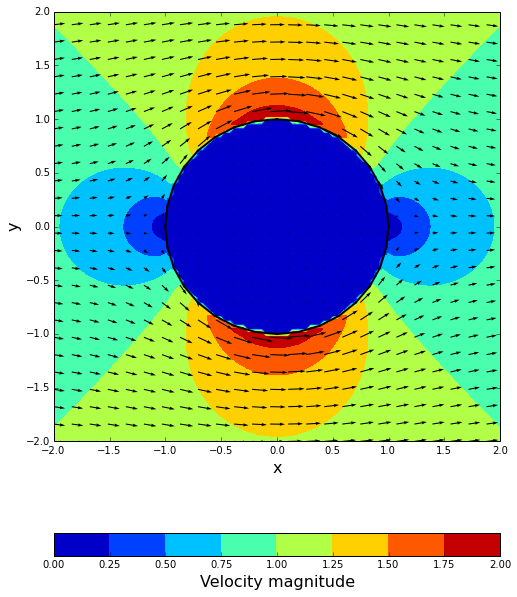

In [7]:
alpha = 0                               # angle of attack
dgamma = 0./(2*numpy.pi)                # vortex circulation

circle = make_circle(N)                 # set-up geom
solve_gamma(circle,alpha)               # find gamma
for p in circle: p.gamma += dgamma      # increase gamma by dgamma
plot_flow(circle,alpha)                 # plot the flow
print('C_L ='+'%.2e'%C_L(circle))

We see that we can add any amount $\Delta\gamma$, and generate any lift we want. This should be unsettling in at least two different ways:

- The solution for $\gamma_i$ to obey the no-slip condition is not unique!
- The vortex circulation (and lift) is completely independent of $\alpha$!
---

Let get the first issue out of the way first. Indeed, $\gamma_i$ is not unique. This is because the matrix $\mathbf A$ for the vortex panel system is *singular*.

##### Numerical fundamental: Singular matrix
##### The solutions to a singular matrix are not unique

We didn't notice this in the last notebook, because rounding errors nudged $\mathbf A$ out of singularity. This is why the solution for the foil at an angle of attack above is completely bogus - the error doesn't nudge you towards the *correct* solution in general.

## The Kutta condition

Unlike the circle, there **is** a unique correct solution for the foil. This is because the foil has a sharp trailing edge.

##### Quiz 3

What does the flow need to look like on the trailing edge?

![Trailing edge options](resources\trailingEdge.png)

1. The flow needs to wrap from the bottom to the top.
1. The flow needs to wrap from the top to the bottom.
1. The flow need to separate from the edge. 

---
The fundamental problem with the solution for the foil above is that the flow is wrapping around the sharp trailing edge. This means that particles traveling on the body streamline *instantly* change direction - which is impossible for any object with mass.

Avoiding this impossibility is called the Kutta condition.

##### Hydrodynamics fundamental: Kutta Condition
##### Potential flow must separate from a sharp trailing edge

This uniquely determines the correct solution $\gamma_i$ and therefore $\Gamma$ and the $C_L$. 

Additionally, this links the angle of attack $\alpha$ to the lift. As $\alpha$ is increased, the amount of circulation increases to enforce the Kutta condition. 

To enforce the Kutta condition in the vortex panel method, we need to convert it into a statement about the strength $\gamma_i$. 

##### Quiz 4

What condition on $\gamma_i$ will enforce the Kutta conditions?

1. $\gamma=U_\infty$ near the trailing edge
1. $\gamma=0$ near the trailing edge
1. $\gamma$ is antisymmetric near the trailing edge, ie $\gamma(-s)=-\gamma(s)$

(Hint: Look at the sketch above. What does it tell you about $\gamma$ near the trailing edge?)

## Adjusted linear system

Now we know the additional condition which makes the solution unique. I have implemented a new `solve_gamma_kutta` function, which is identical to `solve_gamma` but it enforces the condition above.

In [8]:
from VortexPanel import solve_gamma_kutta
help(solve_gamma_kutta)

Help on function solve_gamma_kutta in module VortexPanel:

solve_gamma_kutta(panels, alpha=0)
    # determine gamma while enforcing the Kutta condition on panels[(0,-1)]



And that's it! Let's try it out:

C_L =nan


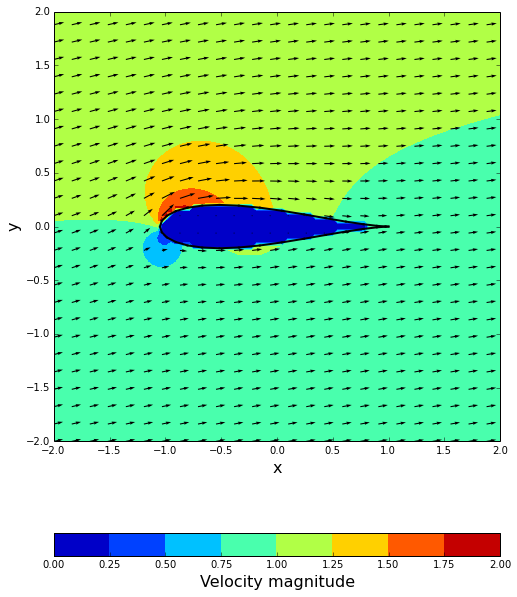

In [9]:
alpha = numpy.pi/16             # angle of attack
solve_gamma_kutta(foil,alpha)   # solve for gamma
plot_flow(foil,alpha)           # plot the flow
print('C_L ='+'%.2e'%C_L(foil))

Compare to the figure above. This one has:

- High speed flow on the top, leading to positive lift.
- Clean separation from the trailing edge.
- The circulation is unique for a given angle of attack.

## Numerical validation

So, is the prediction any good?

##### Numerical fundamental: Validation
##### A method is validated by comparing the result to a known solution

The exact solution for the lift on a Jukowski foil is

$$C_L = 2\pi \left(1+\frac 4{3\sqrt 3} \frac tc \right)\sin\alpha$$

where $t/c$ is the thickness to coord ratio. ie

In [10]:
def jukowski_C_L(alpha,t_c=0.2): 
    return 2*numpy.pi*(1+4/3/numpy.sqrt(3)*t_c)*numpy.sin(alpha)

##### Your turn #4

 - ** Complete ** the function to compute C_L for a given $\alpha$ and geometry. 
 - ** Compute ** the numerical C_L for $\alpha=0,\ldots,15^o$.
 - ** Plot and Compare ** the results against the analytic solution.

In [11]:
def solve_C_L(panels,alpha):
    # your code here
    return C_L

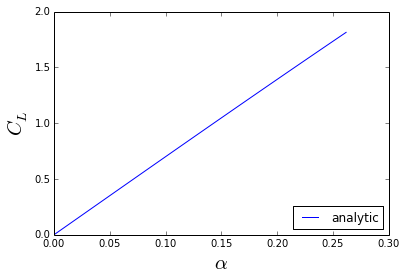

In [12]:
pyplot.xlabel(r'$\alpha$', fontsize=20)
pyplot.ylabel(r'$C_L$', fontsize=20)

alpha = numpy.linspace(0,15)*numpy.pi/180.
pyplot.plot(alpha,jukowski_C_L(alpha), label='analytic')

### your code here

pyplot.legend(loc='lower right')

##### Quiz 6

These lift plots show no evidence of stall. Why not?

1. Insufficient resolution or a numerical bug
1. Potential flow cannot predict separation and therefore misses stall
1. The Jukowski foil is designed specifically to avoid stall